# Question 13: Numerical derivatives

## 13(a) Central Difference Scheme

In [1]:
# Adaoted from the code provided in Lecture Unit 4.

using Plots
using LaTeXStrings

function calculate_numerical_derivative_error(
        x0, f, fprime;
        h_range = 10 .^(-14:0.01:-2),
        diff_scheme = (f, x; h=sqrt(eps())) -> (f(x + h) - f(x)) / h
    )
    errs = [abs(diff_scheme(f, x0; h = h) - fprime(x0))/abs(fprime(x0)) for h in h_range]
    return errs
end

function plot_numerical_derivative_error(x0, f, fprime;
    h_range = 10 .^(-14:0.01:-2),
    diff_scheme = (f, x; h=sqrt(eps())) -> (f(x + h) - f(x)) / h,
    colour = :red,
    label = ""
)
    errs = calculate_numerical_derivative_error(x0, f, fprime; h_range=h_range, diff_scheme=diff_scheme)
    plot(h_range, errs,
        yaxis = :log,xaxis = :log,
        xlabel="h" ,ylabel="Absolute relative error",
        c = colour,
        label=label,
        legend = :bottomleft,
        size=(800, 600),
        title = L"\mathrm{I\ hope\ you\ don't\ have\ colour\ blindness}",
        xticks=10,
        yticks=10,
    )
end

function plot_numerical_derivative_error!(x0, f, fprime;
    h_range = 10 .^(-14:0.01:-2),
    diff_scheme = (f, x; h=sqrt(eps())) -> (f(x + h) - f(x)) / h,
    colour = :red,
    label = ""
)
    errs = calculate_numerical_derivative_error(x0, f, fprime; h_range=h_range, diff_scheme=diff_scheme)
    plot!(h_range, errs,
        c = colour,
        label=label
    )
end

diff_forward(f, x; h = sqrt(eps())) = (f(x + h) - f(x)) / h
diff_central(f, x; h = sqrt(eps())) = (f(x + h/2) - f(x - h/2)) / h

plot_numerical_derivative_error(0.5, x -> sin(x^2), x -> 2x*cos(x^2); diff_scheme=diff_central, colour="#4876c7", label=L"\mathrm{(Cen.)}\ f_1(x) = \sin\left(x^2\right)")
plot_numerical_derivative_error!(0.5, x -> sin(x^2), x -> 2x*cos(x^2); diff_scheme=diff_forward, colour="#30c26b", label=L"\mathrm{(For.)}\ f_1(x) = \sin\left(x^2\right)")

plot_numerical_derivative_error!(1, x -> exp(3*x^2), x -> 6x * exp(3*x^2); diff_scheme=diff_central, colour="#1d4182", label=L"\mathrm{(Cen.)}\ f_2(x) = \exp\left(3x^2\right)")
plot_numerical_derivative_error!(1, x -> exp(3*x^2), x -> 6x * exp(3*x^2); diff_scheme=diff_forward, colour="#3c9e64", label=L"\mathrm{(For.)}\ f_2(x) = \exp\left(3x^2\right)")

f3 = x -> atan(2x) / (1 + exp(-2*x^2))
f3prime = x -> (2*exp(2*x^2)*(1 + exp(2*x^2) + 2*(x + 4*x^3)*atan(2*x))) / ((1 + exp(2*x^2))^2*(1 + 4*x^2))
plot_numerical_derivative_error!(2, f3, f3prime; diff_scheme=diff_central, colour="#648dd9", label=L"\mathrm{(Cen.)}\ f_3(x) = \arctan\left(2x\right) / \left(1 + \exp\left(-2x^2\right)\right)")
plot_numerical_derivative_error!(2, f3, f3prime; diff_scheme=diff_forward, colour=:"#0f6331", label=L"\mathrm{(For.)}\ f_3(x) = \arctan\left(2x\right) / \left(1 + \exp\left(-2x^2\right)\right)")

critical_h = 10^(-5.6)
plot!([critical_h, critical_h], [eps(), 10e0], lw=4, label=L"\mathrm{Critical}~ h~ \mathrm{value}")

savefig("./figure.png")

"/workspaces/Julia-Codespaces/dev/figure.png"

## 13(b) Softmax Evaluations of Vector Function Jacobian with Forwards vs Central Difference Scheme

The forward difference scheme needs $K+1$ `softmax` evaluations, while the central difference scheme requires $2K$. This is because each softmax call returns all $K$ output components at once, so one call per perturbed coordinate gives a whole column of the Jacobian. The forward difference calls it once at a time, while the central difference scheme calls it twice.

## 13(c) Error of Jacobian using Forwards vs Central Difference Schemes

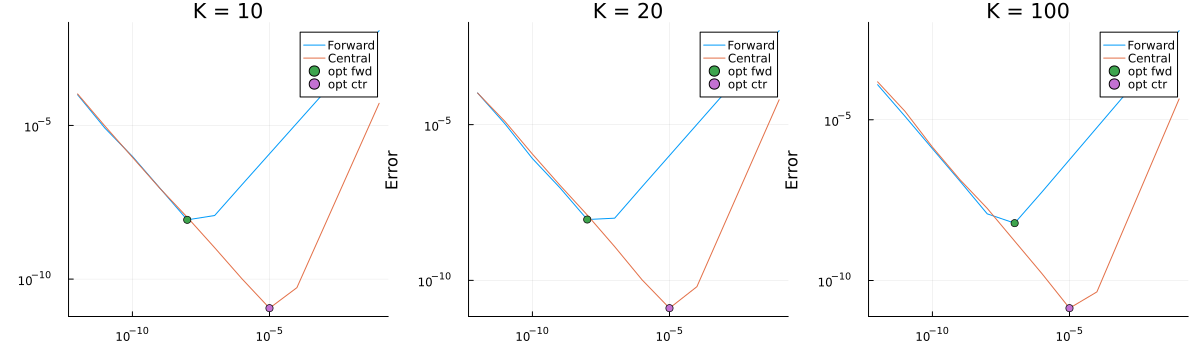


K = 10
	Forward: min error = 8.492e-09 at h = 1.0e-08
	Central: min error = 1.133e-11 at h = 1.0e-05

K = 20
	Forward: min error = 8.981e-09 at h = 1.0e-08
	Central: min error = 1.278e-11 at h = 1.0e-05

K = 100
	Forward: min error = 6.070e-09 at h = 1.0e-07
	Central: min error = 1.377e-11 at h = 1.0e-05


In [6]:
using LinearAlgebra
using Printf
using Plots

function S(z)
    return exp.(z) / sum(exp.(z))
end

function softmax_jacobian(z)
    K = length(z)
    J = zeros(Float64, K, K)
    softmax = S(z)
    for i = 1:K
        Szi = softmax[i]
        for j = 1:K
            Szj = softmax[j]
            if i == j
                J[i,j] = Szi * (1 - Szi)
            else
                J[i,j] = -Szi * Szj
            end
        end
    end
    return J
end

function jacobian_forward_scheme(z, h)
    K = length(z)
    softmax = S(z)
    J = zeros(Float64, K, K)
    z_plus_h = copy(z)
    for j in 1:K
        z_plus_h[j] = z[j] + h
        Sj = S(z_plus_h)
        J[:, j] = (Sj - softmax) / h
        z_plus_h[j] = z[j]
    end
    return J
end

function jacobian_central_scheme(z, h)
    K = length(z)
    J = zeros(Float64, K, K)
    z_plus_h = copy(z)
    for j in 1:K
        z_plus_h[j] = z[j] + 0.5h
        Sp = S(z_plus_h)
        z_plus_h[j] = z[j] - 0.5h
        Sm = S(z_plus_h)
        J[:, j] = (Sp - Sm) / h
        z_plus_h[j] = z[j]
    end
    return J
end


hs = 10.0 .^ (-1:-1:-12)
Ks = [10, 20, 100]
results = Dict()

for K in Ks
    z = [i^(1/3) for i in 1:K]
    Jtrue = softmax_jacobian(z)

    err_f = similar(hs)
    err_c = similar(hs)

    for (t, h) in enumerate(hs)
        Jf = jacobian_forward_scheme(z, h)
        Jc = jacobian_central_scheme(z, h)
        err_f[t] = norm(Jf - Jtrue)
        err_c[t] = norm(Jc - Jtrue)
    end


    i_f = argmin(err_f)
    i_c = argmin(err_c)
    @printf "\nK = %d\n" K
    @printf "\tForward: min error = %.3e at h = %.1e\n" err_f[i_f] hs[i_f]
    @printf "\tCentral: min error = %.3e at h = %.1e\n" err_c[i_c] hs[i_c]

    results[K] = (hs=hs, err_f=err_f, err_c=err_c, hopt_f=hs[i_f], hopt_c=hs[i_c])
end


plt = plot(layout=(1,3), size=(1200,350))
for (pidx, K) in enumerate(Ks)
    r = results[K]
    plot!(plt[pidx], r[:hs], r[:err_f], xscale=:log10, yscale=:log10,
        xlabel="h", ylabel="Error",
        label="Forward", title="K = $K")
    plot!(plt[pidx], r[:hs], r[:err_c], xscale=:log10, yscale=:log10,
        label="Central")
    scatter!(plt[pidx], [r[:hopt_f]], [minimum(r[:err_f])], label="opt fwd", markersize=4)
    scatter!(plt[pidx], [r[:hopt_c]], [minimum(r[:err_c])], label="opt ctr", markersize=4)
end

display(plt)